# About Sync Mode

Some users may have such a request: they do not want to use the complex graph combination and connection of the BMF framework, but want to use the ability of a certain module alone. Sync Mode provides users with a function of directly invoking module capabilities in an atomic form. Users can directly call the functions of the module without building a graph, as shown in the following figure:

This article mainly introduces the implementation of Sync Mode Python. Go and C++ also have corresponding implementation mechanisms:

C++：To be added

Go：To be added

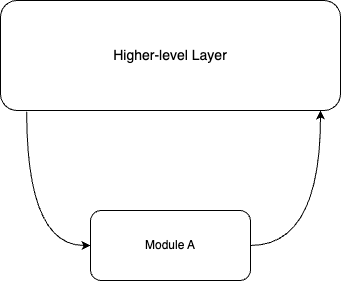




# 1. Install BMF in Python environment.

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/10slUmZnf0x8rOpKUcAnOPFTKYa6tW91S/view?usp=sharing -O bmf-0.1.0-cp310-none-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=10slUmZnf0x8rOpKUcAnOPFTKYa6tW91S
To: /content/bmf-0.1.0-cp310-none-linux_x86_64.whl
100% 52.6M/52.6M [00:00<00:00, 109MB/s] 


In [2]:
!pip install bmf-0.1.0-cp310-none-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./bmf-0.1.0-cp310-none-linux_x86_64.whl


## 2.The Engine layer of the BMF framework is uniformly implemented in C++ language. In Colab, when python calls the C++ library, the log of the C++ library layer will be hidden, so it is necessary to install and load the wurlitezer library to enable logs in the C++ layer.

In [3]:
!pip install wurlitzer
%load_ext wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 3. Download a sample transcoded video (using Big Bunny as an example here).

In [4]:
!gdown --fuzzy https://drive.google.com/file/d/1l8bDSrWn6643aDhyaocVStXdoUbVC3o2/view?usp=sharing -O big_bunny_10s_30fps.mp4

Downloading...
From: https://drive.google.com/uc?id=1l8bDSrWn6643aDhyaocVStXdoUbVC3o2
To: /content/big_bunny_10s_30fps.mp4
100% 2.56M/2.56M [00:00<00:00, 244MB/s]


## 4. Write and implement a sync mode calling code.
### This piece of code first calls the bmf_sync.sync_module interface to create four bmf modules (c_ffmpeg_decoder, c_ffmpeg_filter (Scale), c_ffmpeg_filter (volume), c_ffmpeg_encoder). Afterwards, it continuously reads the video stream from the input video by loop, decodes frame by frame, and first sends it to a Scale Filter Module to scale the video to a resolution of 320x250. Then, the processed video frame is obtained and sent to a volume Filter Module to adjust the volume once. Finally, the video is sent to the Encoder Module for video encoding and saved as a file. Let's complete the demo implementation of sync mode through two sub-steps

### 4.1 Creating Sync Modules
In this code, we first called the bmf.sync_module interface to create three modules. The definition of this interface follows as below.

```
def bmf.builder.bmf_sync.sync_module (
   name, 
   option, 
   input_streams, 
   output_streams 
)

Create SyncModule by name, option, input_stream_id_list and output_stream_id_list.

Parameters

name the name for the module
option the option for the module
input_streams the input stream id list for the module
output_streams the output stream id list for the module

Returns
bmf_sync.SyncModule

```

Using the interface above, we created one Decoder module, two Filter modules, and one Encoder module. For the Decoder module, we set up two output streams (encoded as number 0 and number 1), where number 0 corresponds to the video stream and number 1 corresponds to the audio stream. For the two Filter modules, Scale and Volume, we set up one input stream and one output stream each, with a unified number of 0. Finally, the Encoder module takes in two input streams and has no output stream, as the Encoder module will encode the processed video stream and save it to disk.


  


In [5]:
import bmf
from bmf import bmf_sync, Packet
input_video_path = "./big_bunny_10s_30fps.mp4"
output_path = "./video.mp4"

# create sync modules
decoder = bmf_sync.sync_module("c_ffmpeg_decoder", {"input_path": input_video_path}, [], [0, 1])
scale = bmf_sync.sync_module("c_ffmpeg_filter", {
    "name": "scale",
    "para": "320, 250"
}, [0], [0])
volume = bmf_sync.sync_module("c_ffmpeg_filter", {
    "name": "volume",
    "para": "volume=3"
}, [0], [0])
encoder = bmf_sync.sync_module("c_ffmpeg_encoder", {
    "output_path": output_path
}, [0, 1], [])


[2023-06-05 10:11:12.274] [info] c_ffmpeg_decoder c++ /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so libbuiltin_modules.CFFDecoder
[2023-06-05 10:11:12.278] [info] Module info c_ffmpeg_decoder c++ libbuiltin_modules.CFFDecoder /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so
[2023-06-05 10:11:12.284] [info] Constructing c++ module
[2023-06-05 10:11:12.386] [info] c++ module constructed
[2023-06-05 10:11:12.387] [info] c_ffmpeg_filter c++ /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so libbuiltin_modules.CFFFilter
[2023-06-05 10:11:12.387] [info] Module info c_ffmpeg_filter c++ libbuiltin_modules.CFFFilter /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so
[2023-06-05 10:11:12.387] [info] Constructing c++ module
[2023-06-05 10:11:12.387] [info] c++ module constructed
[2023-06-05 10:11:12.392] [info] Constructing c++ module
[2023-06-05 10:11:12.392] [info] c++ module constructed
[2023-06-05 10:11:12.392]

## 4.2 Writing and Implementing Pipeline Code

In the process described above, we have built the required 4 syncModules, let's write a pipeline to implement a video processing process as shown in the figure below:

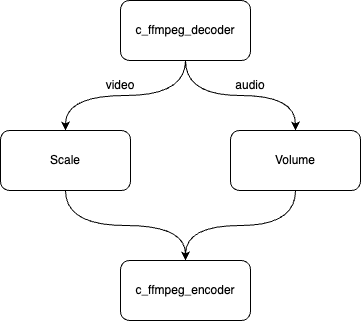

When we build the pipeline, we mainly call the bmf_sync.process interface, which should be defined as follows:


```
def bmf.builder.bmf_sync.process (
  module, 
  pkts_dict 
)   

Directly do module processing.

Parameters

module corresponding syncModule object
pkts_dict a dict which contains all input data packet

Returns
result_dict, task.timestamp
```
Using this interface, we combined the modules created above and used a dictionary to map the input pkt to the InputStream and OutputStream of the syncModule one by one, then implemented the entire video processing pipeline.



In [6]:
# process video/audio by sync mode
while True:
    frames, _ = bmf_sync.process(decoder, None)
    has_next = False
    for key in frames:
        if len(frames[key]) > 0:
            has_next = True
            break
    if not has_next:
        bmf_sync.send_eof(encoder)
        break
    if 0 in frames.keys() and len(frames[0]) > 0:
        frames, _ = bmf_sync.process(scale, {0: frames[0]})
        bmf_sync.process(encoder, {0: frames[0]})
    if 1 in frames.keys() and len(frames[1]) > 0:
        frames, _ = bmf_sync.process(volume, {0: frames[1]})
        bmf_sync.process(encoder, {1: frames[0]})

[2023-06-05 10:11:18.437] [info] node id:-1 decode flushing


## 5. Display the video streams before and after processing.

In [7]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return f"""
  <video width={video_width} controls>
    <source src="{video_url}">
  </video>
  """
  
video_url1 = show_video('big_bunny_10s_30fps.mp4')
video_url2 = show_video('video.mp4')

html = video_url1 + video_url2
HTML(html)